<a href="https://colab.research.google.com/github/vinayak2019/ml_for_molecules/blob/main/Modify_ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Creating custom ML models

So far we have used ML models available in the python packages. Here, we will look into the code for the models and see how we can tweek it to make new ML models.

We will use the MPNN model from `dgl` and make changes to the model. We will test those models on a subset of the QM9 dataset as before. 



### Installing packages and creating the dataloader

In [ ]:
# install dgl, rdkit and fast-ml
! pip install dgl
! pip install dgllife
! pip install rdkit
! pip install fast_ml

In [ ]:
# import pandas library
import pandas as pd

# load the dataframe as CSV from URL. 
df = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv")

# create the dataset with smiles and gap
# we will use a 5% of the dataset to save time
dataset = df[["smiles","gap"]].sample(frac=0.05)

# import from rdkit and dgl-lifesci
from rdkit import Chem
from dgllife.utils import CanonicalAtomFeaturizer, CanonicalBondFeaturizer, \
mol_to_bigraph

# create the atom and bond featurizer object
atom_featurizer = CanonicalAtomFeaturizer(atom_data_field="hv")
bond_featurizer = CanonicalBondFeaturizer(bond_data_field="he")

# helper function to convert smiles to graph
def smiles2graph(smiles):
  mol = Chem.MolFromSmiles(smiles)
  graph = mol_to_bigraph(mol, node_featurizer=atom_featurizer, 
                     edge_featurizer=bond_featurizer)
  return graph

dataset["graph"] = dataset["smiles"].apply(smiles2graph)


# import the function to split into train-valid-test
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, \
X_test, y_test = train_valid_test_split(dataset[["graph","gap"]], 
                                        target = "gap", 
                                        train_size=0.8,
                                        valid_size=0.1, 
                                        test_size=0.1)

# Creating dataloader
import dgl

def collate_data(data):
  # our data is in the form of list of (X,y)
  # the map function thus maps accordingly
  graphs, y = map(list, zip(*data))

  # for creating a batch of graph, we use the batch function
  batch_graph = dgl.batch(graphs)

  # we need to stack the ys for different entries in the batch
  y = torch.stack(y, dim=0)

  return batch_graph, y

# import dataloader
import torch
from torch.utils.data import DataLoader

# create the dataloader for train dataset
# dataset should be of form (X,y) according to the collate function
# the ys should also be converted to tensors
train_dataloader = DataLoader(
    dataset=list(zip(X_train["graph"].values.tolist(),
                     torch.tensor(y_train.tolist(), dtype=torch.float32))),
    batch_size=64, collate_fn=collate_data)

valid_dataloader = DataLoader(
    dataset=list(zip(X_valid["graph"].values.tolist(),
                     torch.tensor(y_valid.tolist(), dtype=torch.float32))),
    batch_size=64, collate_fn=collate_data)

test_dataloader = DataLoader(
    dataset=list(zip(X_test["graph"].values.tolist(),
                     torch.tensor(y_test.tolist(), dtype=torch.float32))),
    batch_size=64, collate_fn=collate_data)

# loss function for regresssion is usually mean squared error
import torch

loss_func = torch.nn.MSELoss(reduce=None)

We will create a function to train and validate the model

In [ ]:
def run_train_valid(model, optimizer, loss_func,
                    train_dataloader, valid_dataloader):

      epochs = 1

      # loop over epochs
      for epoch in range(epochs):
        print("\nStarting Epoch", epoch+1)

        # set the model to train so the parameters can be updated
        model.train()
        # loop over training batches

        train_loss = []
        for batch in train_dataloader: 

          # Do a forward pass
          batch_graph, target = batch

          # look at the forward function for input
          # this model needs graph, node_feats and edge_feats
          node_feats = batch_graph.ndata["hv"]
          edge_feats = batch_graph.edata["he"]
          predictions = model(batch_graph, node_feats, edge_feats)
        
          # Compute loss
          loss = (loss_func(predictions, target)).mean()
          optimizer.zero_grad()

          # Do back propogation and update gradient
          loss.backward()
          optimizer.step()

          # save loss to compute average loss
          train_loss.append(loss)

        print("Training loss", torch.tensor(train_loss).mean().item())


        
        # set the model to eval so the parameters are not updated
        model.eval()
        valid_loss = []

        # loop over validation batches
        with torch.no_grad():
          for batch in valid_dataloader:
            
            # Do a forward pass
            batch_graph, target = batch
            node_feats = batch_graph.ndata["hv"]
            edge_feats = batch_graph.edata["he"]
            predictions = model(batch_graph, node_feats, edge_feats)
          
            # Compute loss and gradient
            loss = (loss_func(predictions, target)).mean()

            # save loss to compute average loss
            valid_loss.append(loss)
            
        print("Validation loss", torch.tensor(valid_loss).mean().item())


### Training the default MPNN model

In [ ]:
# import MLP model from dgl-lifesci
from dgllife.model.model_zoo.mpnn_predictor import MPNNPredictor

# the atom feature length is 74 and bond is 12
model = MPNNPredictor(node_in_feats = 74, 
                      edge_in_feats = 12, 
                      node_out_feats = 64, 
                      edge_hidden_feats = 128,
                      n_tasks = 1,
                      num_step_message_passing = 6,
                      num_step_set2set = 6,
                      num_layer_set2set = 3)

# adam optimier
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training the model
run_train_valid(model=model, loss_func=loss_func,
                optimizer=optimizer, train_dataloader=train_dataloader,
                valid_dataloader=valid_dataloader)

### Changing the ML init code

Below is the code for the MPNNPredictor from [dgl](https://github.com/awslabs/dgl-lifesci/blob/master/python/dgllife/model/model_zoo/mpnn_predictor.py)



```
import torch.nn as nn

from dgl.nn.pytorch import Set2Set

from dgllife.model.gnn import MPNNGNN

class MPNNPredictor(nn.Module):
    """MPNN for regression and classification on graphs.

    MPNN is introduced in `Neural Message Passing for Quantum Chemistry
    <https://arxiv.org/abs/1704.01212>`__.

    Parameters
    ----------
    node_in_feats : int
        Size for the input node features.
    edge_in_feats : int
        Size for the input edge features.
    node_out_feats : int
        Size for the output node representations. Default to 64.
    edge_hidden_feats : int
        Size for the hidden edge representations. Default to 128.
    n_tasks : int
        Number of tasks, which is also the output size. Default to 1.
    num_step_message_passing : int
        Number of message passing steps. Default to 6.
    num_step_set2set : int
        Number of set2set steps. Default to 6.
    num_layer_set2set : int
        Number of set2set layers. Default to 3.
    """
    def __init__(self,
                 node_in_feats,
                 edge_in_feats,
                 node_out_feats=64,
                 edge_hidden_feats=128,
                 n_tasks=1,
                 num_step_message_passing=6,
                 num_step_set2set=6,
                 num_layer_set2set=3):
        super(MPNNPredictor, self).__init__()

        self.gnn = MPNNGNN(node_in_feats=node_in_feats,
                           node_out_feats=node_out_feats,
                           edge_in_feats=edge_in_feats,
                           edge_hidden_feats=edge_hidden_feats,
                           num_step_message_passing=num_step_message_passing)
        self.readout = Set2Set(input_dim=node_out_feats,
                               n_iters=num_step_set2set,
                               n_layers=num_layer_set2set)
        self.predict = nn.Sequential(
            nn.Linear(2 * node_out_feats, node_out_feats),
            nn.ReLU(),
            nn.Linear(node_out_feats, n_tasks)
        )

    def forward(self, g, node_feats, edge_feats):
        """Graph-level regression/soft classification.

        Parameters
        ----------
        g : DGLGraph
            DGLGraph for a batch of graphs.
        node_feats : float32 tensor of shape (V, node_in_feats)
            Input node features.
        edge_feats : float32 tensor of shape (E, edge_in_feats)
            Input edge features.

        Returns
        -------
        float32 tensor of shape (G, n_tasks)
            Prediction for the graphs in the batch. G for the number of graphs.
        """
        node_feats = self.gnn(g, node_feats, edge_feats)
        graph_feats = self.readout(g, node_feats)
        return self.predict(graph_feats)
```



Let's say we want to add one more `Linear` layer to the *predict* with `ReLU` activation. We copy paste the entire class and make that change. 

We will call the model *MPNN_modified*

In [ ]:
# add the import statements
import torch.nn as nn
from dgl.nn.pytorch import Set2Set
from dgllife.model.gnn import MPNNGNN

# creating the class; change the class name
class MPNN_modified(nn.Module):
    
    def __init__(self,
                 node_in_feats,
                 edge_in_feats,
                 node_out_feats=64,
                 edge_hidden_feats=128,
                 n_tasks=1,
                 num_step_message_passing=6,
                 num_step_set2set=6,
                 num_layer_set2set=3):
      
        # don't forget to change the class name in super
        super(MPNN_modified, self).__init__()

        self.gnn = MPNNGNN(node_in_feats=node_in_feats,
                           node_out_feats=node_out_feats,
                           edge_in_feats=edge_in_feats,
                           edge_hidden_feats=edge_hidden_feats,
                           num_step_message_passing=num_step_message_passing)
        self.readout = Set2Set(input_dim=node_out_feats,
                               n_iters=num_step_set2set,
                               n_layers=num_layer_set2set)
        self.predict = nn.Sequential(
            nn.Linear(2 * node_out_feats, node_out_feats),
            nn.ReLU(),


            #################################
            # let's add a linear layer followed by ReLU
            # the input size should match the output of previous layer
            nn.Linear(node_out_feats, 2 * node_out_feats),
            nn.ReLU(),

            ######################################
            nn.Linear(2 * node_out_feats, n_tasks)
        )

    # No change here as we did not change the gnn, readout or predict inputs
    def forward(self, g, node_feats, edge_feats):
      
        node_feats = self.gnn(g, node_feats, edge_feats)
        graph_feats = self.readout(g, node_feats)
        return self.predict(graph_feats)

Now we can train this ML model. The model parameters have not changed. So, we can use the same parameters as before.

In [ ]:
# the atom feature length is 74 and bond is 12
model = MPNN_modified(node_in_feats = 74, 
                      edge_in_feats = 12, 
                      node_out_feats = 64, 
                      edge_hidden_feats = 128,
                      n_tasks = 1,
                      num_step_message_passing = 6,
                      num_step_set2set = 6,
                      num_layer_set2set = 3)

# adam optimier
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training the model
run_train_valid(model=model, loss_func=loss_func,
                optimizer=optimizer, train_dataloader=train_dataloader,
                valid_dataloader=valid_dataloader)

The training code works! Suppose we wanted to control the number of linear layers added using a argument to the model, for example, *num_linear_layers*.

We will do that in the following code

In [ ]:
# add the import statements
import torch.nn as nn
from dgl.nn.pytorch import Set2Set
from dgllife.model.gnn import MPNNGNN

# creating the class; change the class name
class MPNN_modified(nn.Module):
    
    def __init__(self,
                 node_in_feats,
                 edge_in_feats,
                 node_out_feats=64,
                 edge_hidden_feats=128,
                 n_tasks=1,
                 num_step_message_passing=6,
                 num_step_set2set=6,
                 num_layer_set2set=3,
                 # add the num_linear_layers
                 num_linear_layers = 1
                 ):
      
        # don't forget to change the class name in super
        super(MPNN_modified, self).__init__()

        self.gnn = MPNNGNN(node_in_feats=node_in_feats,
                           node_out_feats=node_out_feats,
                           edge_in_feats=edge_in_feats,
                           edge_hidden_feats=edge_hidden_feats,
                           num_step_message_passing=num_step_message_passing)
        self.readout = Set2Set(input_dim=node_out_feats,
                               n_iters=num_step_set2set,
                               n_layers=num_layer_set2set)
        
        ######################################
        # we can use a for loop to add desired number of layers
        layers = []
        for i in range(num_linear_layers):
              layers.append(nn.Linear(node_out_feats, node_out_feats))
              layers.append(nn.ReLU())

        ######################################

        self.predict = nn.Sequential(
            nn.Linear(2 * node_out_feats, node_out_feats),
            nn.ReLU(),

            ## adding the linear layers
            nn.Sequential(*layers),

            nn.Linear(node_out_feats, n_tasks)
        )

    # No change here as we did not change the gnn, readout or predict inputs
    def forward(self, g, node_feats, edge_feats):
      
        node_feats = self.gnn(g, node_feats, edge_feats)
        graph_feats = self.readout(g, node_feats)
        return self.predict(graph_feats)

Let's look at the `model.predict` with `num_linear_layers` set to 1

In [ ]:
model = MPNN_modified(node_in_feats = 74, 
                      edge_in_feats = 12, 
                      node_out_feats = 64, 
                      edge_hidden_feats = 128,
                      n_tasks = 1,
                      num_step_message_passing = 6,
                      num_step_set2set = 6,
                      num_layer_set2set = 3,
                      num_linear_layers=1)
model.predict


Let's add 3 layers and train the model

In [ ]:
model = MPNN_modified(node_in_feats = 74, 
                      edge_in_feats = 12, 
                      node_out_feats = 64, 
                      edge_hidden_feats = 128,
                      n_tasks = 1,
                      num_step_message_passing = 6,
                      num_step_set2set = 6,
                      num_layer_set2set = 3,
                      num_linear_layers=3)
model.predict


In [ ]:
# adam optimier
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training the model
run_train_valid(model=model, loss_func=loss_func,
                optimizer=optimizer, train_dataloader=train_dataloader,
                valid_dataloader=valid_dataloader)

### Changes to forward function

In a published [article](https://pubs.acs.org/doi/10.1021/acs.jcim.9b00237) addiding fingerprints or descriptors to the output from readout layer was found to increase the prediction accuracy

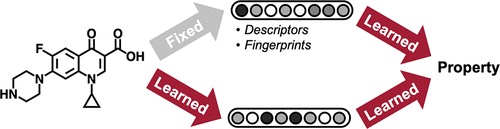

In such cases, we will need to modify the `forward` to take in the descriptors/fingerprints. Here, for sake of simplicity, we will just modify the `forward` function to multiply the output readout by a constant  

In [ ]:
# add the import statements
import torch.nn as nn
from dgl.nn.pytorch import Set2Set
from dgllife.model.gnn import MPNNGNN

# creating the class; change the class name
class MPNN_modified(nn.Module):
    
    def __init__(self,
                 node_in_feats,
                 edge_in_feats,
                 node_out_feats=64,
                 edge_hidden_feats=128,
                 n_tasks=1,
                 num_step_message_passing=6,
                 num_step_set2set=6,
                 num_layer_set2set=3,
                 ):
      
        # don't forget to change the class name in super
        super(MPNN_modified, self).__init__()

        self.gnn = MPNNGNN(node_in_feats=node_in_feats,
                           node_out_feats=node_out_feats,
                           edge_in_feats=edge_in_feats,
                           edge_hidden_feats=edge_hidden_feats,
                           num_step_message_passing=num_step_message_passing)
        self.readout = Set2Set(input_dim=node_out_feats,
                               n_iters=num_step_set2set,
                               n_layers=num_layer_set2set)

        self.predict = nn.Sequential(
            nn.Linear(2 * node_out_feats, node_out_feats),
            nn.ReLU(),
            nn.Linear(node_out_feats, n_tasks)
        )

    # take in to constant value and multiply the readout output
    def forward(self, g, node_feats, edge_feats, constant):
      
        node_feats = self.gnn(g, node_feats, edge_feats)
        graph_feats = self.readout(g, node_feats)
        
        #############################################
        print("Old",graph_feats,flush=True)

        # do the multiplication
        new_graph_feats = graph_feats * torch.tensor(constant)

        print("New",new_graph_feats,flush=True)

        #################################################

        return self.predict(new_graph_feats)

Let's train this model. You will not see any changes in the model itself.

In [ ]:
model = MPNN_modified(node_in_feats = 74, 
                      edge_in_feats = 12, 
                      node_out_feats = 64, 
                      edge_hidden_feats = 128,
                      n_tasks = 1,
                      num_step_message_passing = 6,
                      num_step_set2set = 6,
                      num_layer_set2set = 3
)
model


We will have to change the `run_train_valid` function to include the constant as input to the model

In [ ]:
def run_train_valid_modified(model, optimizer, loss_func,
                    train_dataloader, valid_dataloader):

      epochs = 1

      # loop over epochs
      for epoch in range(epochs):
        print("\nStarting Epoch", epoch+1)

        # set the model to train so the parameters can be updated
        model.train()
        # loop over training batches

        train_loss = []
        for batch in train_dataloader: 

          # Do a forward pass
          batch_graph, target = batch

          # look at the forward function for input
          # this model needs graph, node_feats and edge_feats
          node_feats = batch_graph.ndata["hv"]
          edge_feats = batch_graph.edata["he"]

          ###################################################
          # adding the constant
          predictions = model(batch_graph, node_feats, edge_feats, 10)
          ######################################################

          
          # Compute loss
          loss = (loss_func(predictions, target)).mean()
          optimizer.zero_grad()

          # Do back propogation and update gradient
          loss.backward()
          optimizer.step()

          # save loss to compute average loss
          train_loss.append(loss)

        print("Training loss", torch.tensor(train_loss).mean().item())


        
        # set the model to eval so the parameters are not updated
        model.eval()
        valid_loss = []

        # loop over validation batches
        with torch.no_grad():
          for batch in valid_dataloader:
            
            # Do a forward pass
            batch_graph, target = batch
            node_feats = batch_graph.ndata["hv"]
            edge_feats = batch_graph.edata["he"]

            #####################################################
            # adding the constant
            predictions = model(batch_graph, node_feats, edge_feats, 10)
            #######################################################

            # Compute loss and gradient
            loss = (loss_func(predictions, target)).mean()

            # save loss to compute average loss
            valid_loss.append(loss)
            
        print("Validation loss", torch.tensor(valid_loss).mean().item())


Finally train the model

In [ ]:
# adam optimier
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training the model
run_train_valid_modified(model=model, loss_func=loss_func,
                optimizer=optimizer, train_dataloader=train_dataloader,
                valid_dataloader=valid_dataloader)